# Prédiction de la demande en électricité sur le marché français

*Etude data - Projet 9 - Nalron (Mai 2020)*\
*OpenClassrooms - ENSAE-ENSAI Formation continue*

*Traitement des données sur Jupyter Notebook (Distribution Anaconda)*\
*Etude réalisée en langage Python*

*Data source*\
[Données mensuelles de consommation totale d'électricité en énergie](http://www.rte-france.com/fr/eco2mix/eco2mix-telechargement)\
[Données météo pour corriger l'effet température](https://cegibat.grdf.fr/simulateur/calcul-dju)

*Les consommations en électricité sont exprimées en Gigawatt (GWh).* 

---

## Correction des données de consommation mensuelles de l'effet température 
L'effet température (dues au chauffage électrique) sera donc corrigé par régression linéaire. Scikit-learn peut-être utilisée ou Statsmodels, à des fins de comparaison les deux méthodes seront traitées.

In [25]:
#Préparation des données pour établir la Régression linéaire 
y=df['consommation']
x=df.drop(columns=['consommation'])

In [26]:
#Régression linéaire par Scikit-learn
#Instanciation et entrainement du modèle
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
#Coefficient de régression linéaire
reg.coef_[0]

48.49191639056928

**Le modèle de Régression linéaire peut également être traité par Statsmodels,  c'est ce que nous allons voir:**

In [28]:
#Préparation des données pour établir la Régression linéaire
y = df['consommation']
x = sm.add_constant(df['dju_chauffage'])

In [29]:
#Nouvelle Régression linéaire par Statsmodels
#Instanciation du modèle et entrainement
reg = sm.OLS(y, x).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1704.
Date:                Tue, 18 Aug 2020   Prob (F-statistic):           1.23e-56
Time:                        10:03:08   Log-Likelihood:                -734.60
No. Observations:                  84   AIC:                             1473.
Df Residuals:                      82   BIC:                             1478.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.164e+04    265.008    119.405

Le coefficient de détermination de 95% est très satisfaisant, de plus il est identique à celui estimé par le précédent modèle via Scikit-learn.

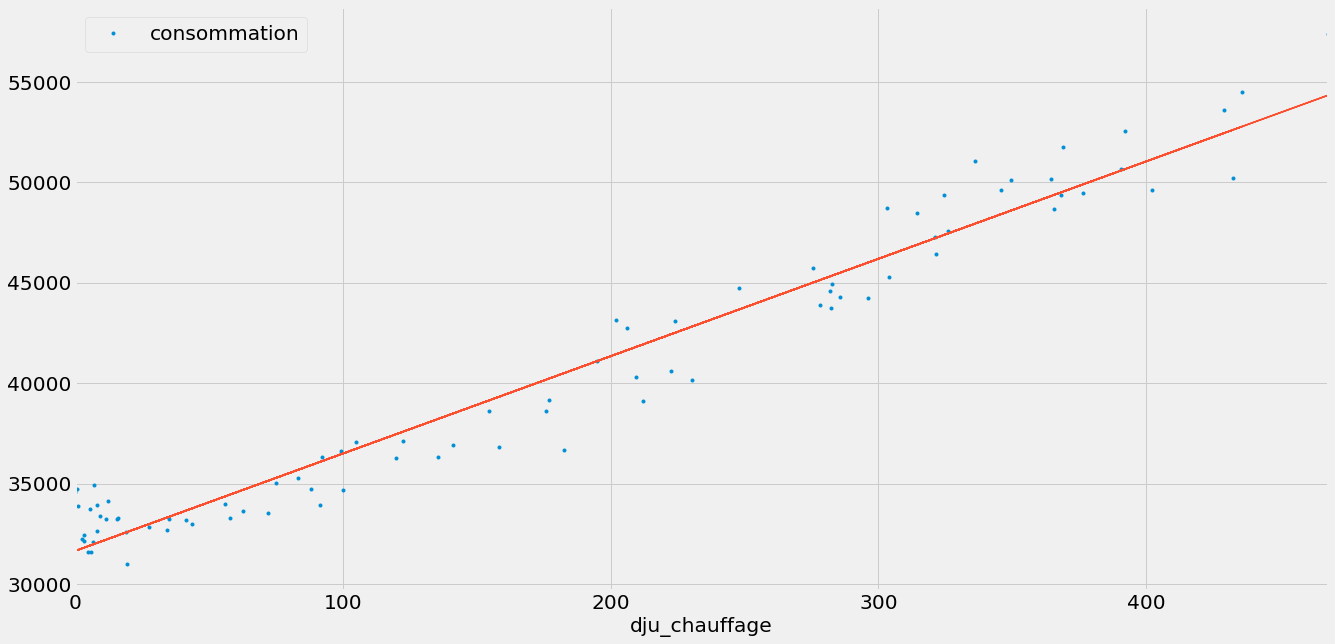

In [30]:
#Représentation de la Régression linéaire obtenue
df.plot(x='dju_chauffage', y='consommation', style='.')
plt.plot(df['dju_chauffage'], reg.predict(sm.add_constant(df['dju_chauffage'])))

plt.savefig("p9_graphic/regression_lineaire_conso_dju.png")
plt.show()

In [31]:
#Coefficient de régression linéaire
reg.params['dju_chauffage']

48.49191639056929

Le coefficient de régression linéaire est vérifié par les deux méthodes.

In [32]:
#Calcul de la correction : l'effet DJU est retranché à la consommation totale
df['conso_corr'] = df['consommation'] - df['dju_chauffage']*reg.params['dju_chauffage']

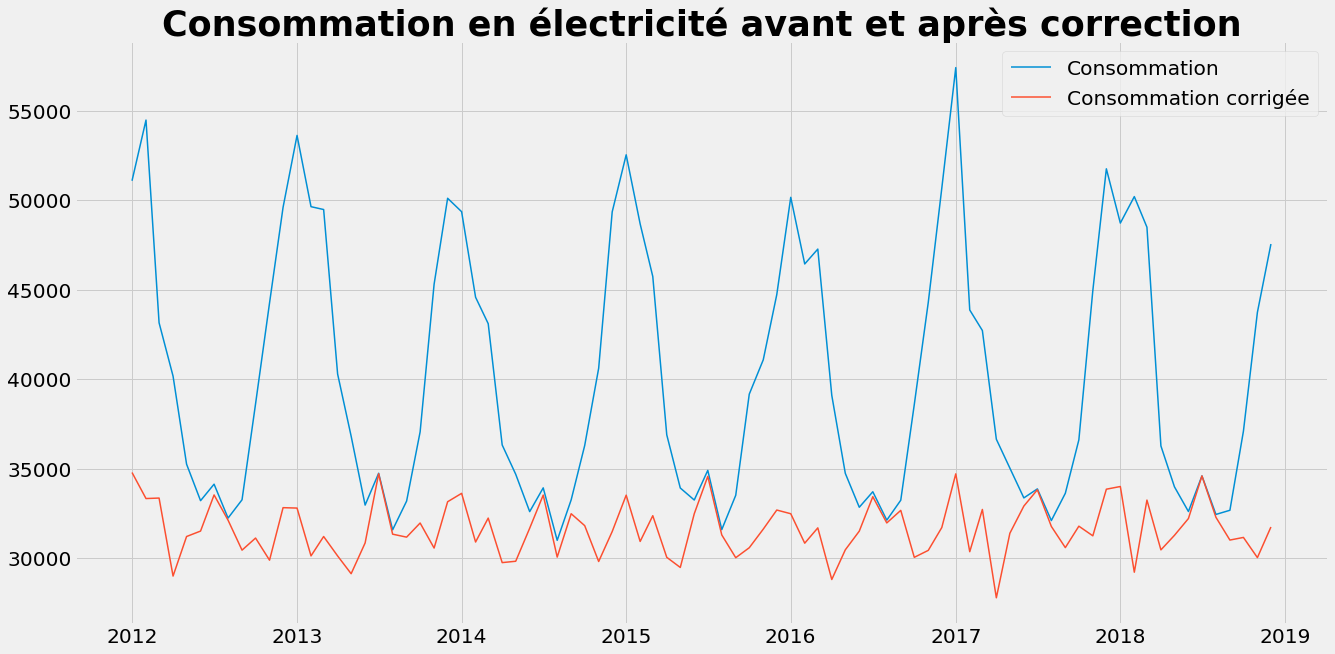

In [33]:
#Visualisation de la consommation en électricité avant et après correction
plt.plot(df['consommation'], label='Consommation')
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.title('Consommation en électricité avant et après correction')

plt.savefig("p9_graphic/conso_corr.png")
plt.legend()
plt.show()

#### Test de normalité des résidus : 
L’inférence dans la régression linéaire repose sur l’hypothèse de normalité des erreurs. *Une première vérification importante consiste à vérifier la compatibilité des résidus (l’erreur observée sur l’échantillon)*.

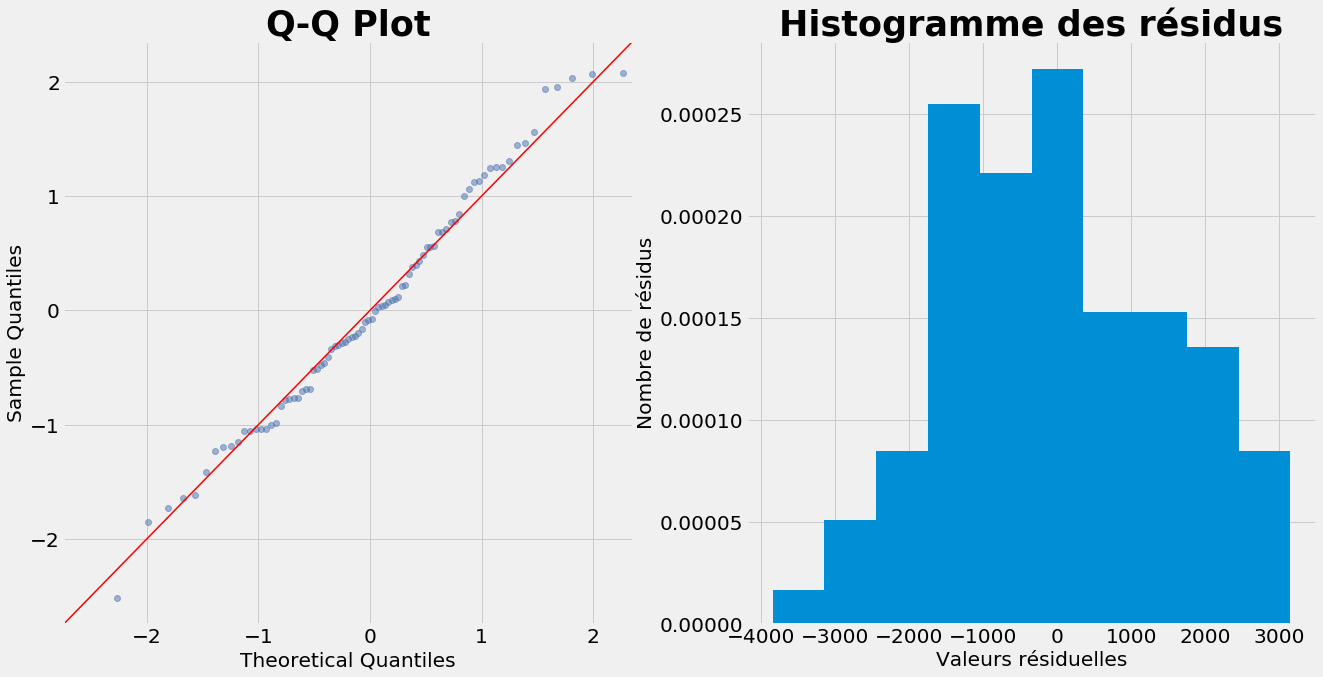

In [34]:
#Distribution des résidus
fig, ax = plt.subplots(1, 2, figsize=(20,10))

plt.hist(reg.resid, density=True)

model_norm_residuals = reg.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])

ax[0].set_title('Q-Q Plot')
ax[1].set_title('Histogramme des résidus')
ax[1].set_xlabel('Valeurs résiduelles')
ax[1].set_ylabel('Nombre de résidus')
                
plt.savefig('p9_graphic/qqplot_histo_residus_reg.jpg')
plt.show()

On peut identifier une distribution des résidus satisfaisante, alignée avec la distribution théorique d'une loi normale. Un test de Shapiro-Wilk est nécessaire pour valider ou rejeter cette intuition.

In [35]:
#Test de Shapiro-Wilk
shapiro(reg.resid)

(0.9864242076873779, 0.5266931056976318)

La p-value de 0.526 ne permet pas de rejeter l'hypothèse nulle H0 de normalité des résidus, le test est donc validé.

### Désaisonnalisation de la consommation obtenue après correction grâce aux moyennes mobiles

La méthode seasonal_decompose de statsmodels permet de visualiser la tendance, la saisonnalité et le résidu du signal.

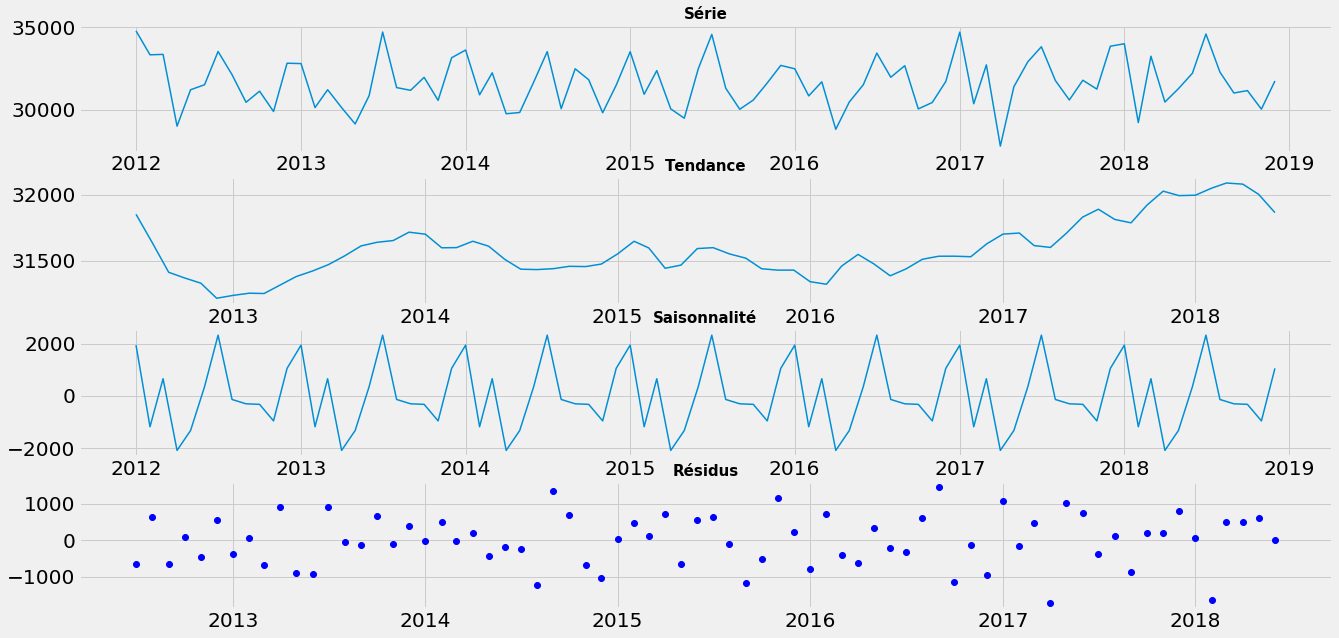

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df['conso_corr'],  model='additive')
fig, ax = plt.subplots(4,1)
ax[0].plot(decomposition.observed)
ax[0].set_title('Série', fontsize=15)
ax[1].plot(decomposition.trend)
ax[1].set_title('Tendance', fontsize=15)
ax[2].plot(decomposition.seasonal)
ax[2].set_title('Saisonnalité', fontsize=15)
ax[3].plot(decomposition.resid,'bo')
ax[3].set_title('Résidus', fontsize=15)

plt.savefig('p9_graphic/decomposition.jpg')
plt.show()

In [37]:
#Différence avec la saisonnalité pour obtenir une série temporelle hors impact saisonnier.
df['conso_cvs'] = df['conso_corr'] - decomposition.seasonal

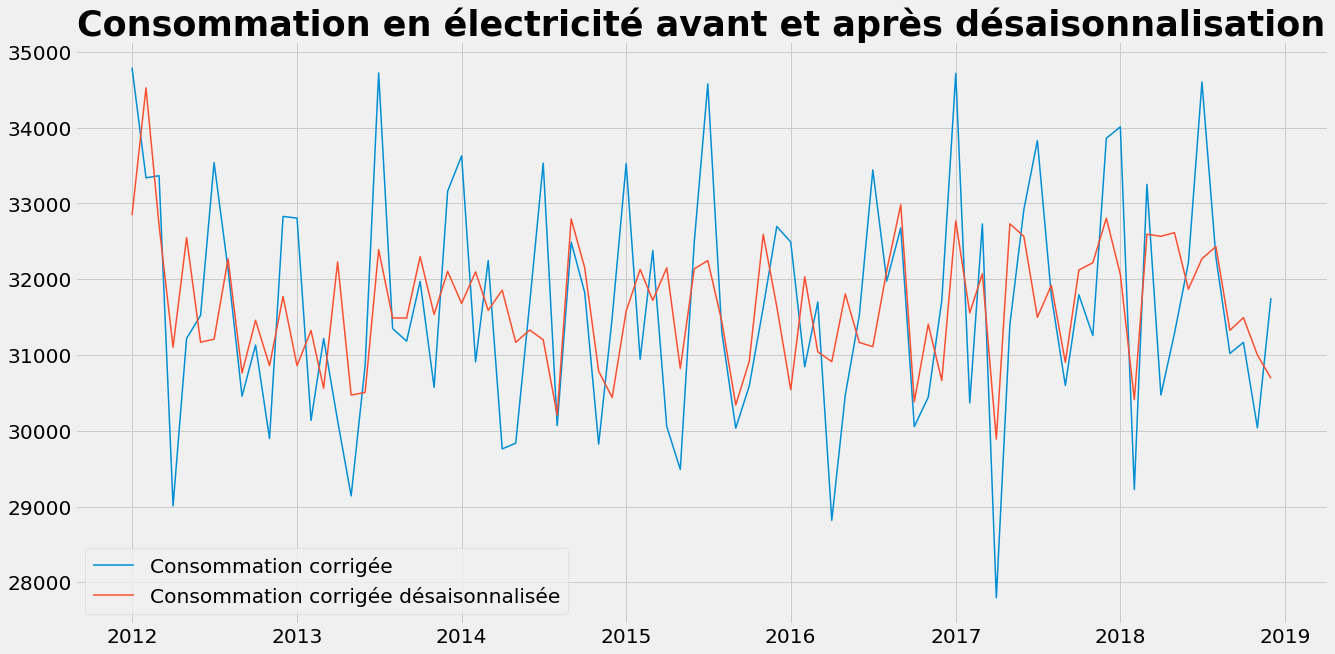

In [38]:
#Visualisation de la consommation en électricité avant et après désaisonnalisation
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(df['conso_cvs'], label='Consommation corrigée désaisonnalisée')
plt.title('Consommation en électricité avant et après désaisonnalisation')

plt.savefig("p9_graphic/conso_cvs.png")
plt.legend()
plt.show()

Le signal ressort corrigé et désaisonnalisé, il est de plus en plus représentatif d'un modèle additif.

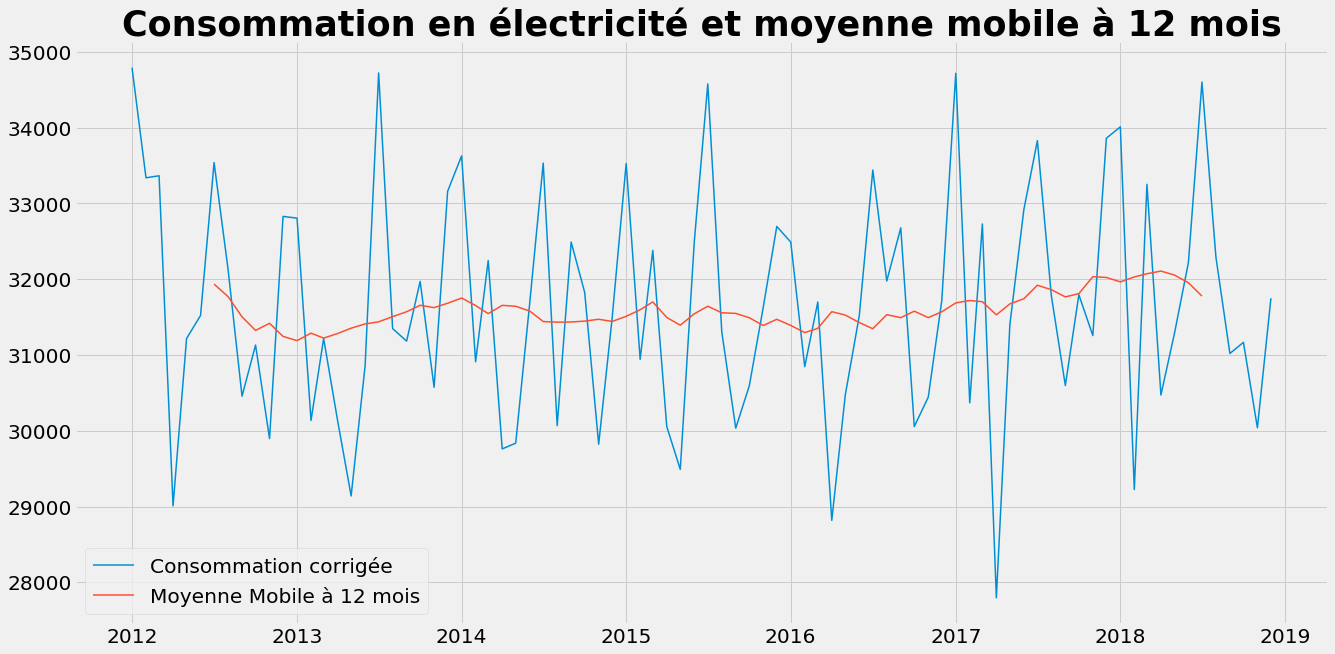

In [39]:
#Visualisation de la consommation en électricité avec moyenne mobile à 12 mois
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(df['conso_corr'].rolling(12, center=True).mean(), label='Moyenne Mobile à 12 mois')


plt.title('Consommation en électricité et moyenne mobile à 12 mois')

plt.savefig("p9_graphic/conso_moyenne_mobile.png")
plt.legend()
plt.show()

Le moyenne mobile à 12 mois affichée ci-dessus est représentative d'un signal sans tendance, constant sur le timeframe.

[Retour vers la page notebook précédente (Traitement des données brutes RTE, GRDF…)](https://github.com/nalron/project_electricity_forecasting/blob/french_version/p9_notebook01.ipynb)

[Suite du projet : Prévision de la consommation par modélisation Holt-Winters, SARIMA…](https://github.com/nalron/project_electricity_forecasting/blob/french_version/p9_notebook03.ipynb)